In [13]:
import numpy as np
from sympy import *
import pickle
import os
import pandas as pd
from helper_functions import datamaker, root_finder, exp_analytical_data
import matplotlib.pyplot as plt
import matplotlib

current_directory = str(os.getcwd())  # store the path of the current directory

In [2]:
cm_kpc = 3.086e+21  # number of centimeters in one parsec
pc_kpc = 1e+3  # number of pc in one kpc
cm_pc = cm_kpc/pc_kpc
g_Msun = 1.989e33  # solar mass in g
s_Myr = 1e+6*(365*24*60*60)  # megayears to seconds
cm_km = 1e5  # number of cm in one km


In [3]:

dat_sigmatot= np.array([200])*g_Msun/(cm_pc)** 2
dat_sigmaHI= np.array([2])*g_Msun/(cm_pc)** 2
dat_q= np.array([1])
dat_omega= np.array([0.1])
dat_sigmasfr= np.array([1])*g_Msun/((1e+3*s_Myr)*(cm_pc)**2)
molfrac = np.array([0.1])
T = np.array([1e+4])

dat_sigmaH2 = dat_sigmaHI*(1/(1-molfrac))
dat_sigma = dat_sigmaHI + dat_sigmaH2


kpc_r = np.ones(len(dat_sigma))
r = kpc_r.size  # common radius of the interpolated data



In [6]:
range_fact = np.linspace(1,100,20)
zet = np.array([1])
psi = np.array([1])
bet = np.array([1])
ca = np.array([1])
rk = np.array([0.3])
mu = np.array([(14/11)])
dat_sigma = mu*dat_sigma
obs_array = np.array([dat_sigmatot, dat_sigma, dat_sigmasfr,
                 dat_q, dat_omega])*range_fact
param_array = np.array([zet, T, psi, bet, ca, rk, mu])*np.ones(range_fact.size)
concatenated_array = np.concatenate((obs_array, param_array), axis =0)
data_pass = list(zip(*concatenated_array))

os.chdir(current_directory)

In [7]:

# extracting the expressions
os.chdir(current_directory + '\expressions')
# subprocess.run(["python", "turbulence_expressions.py"])
# subprocess.run(["python", "magnetic_expressions.py"])


with open('turb_exp.pickle', 'rb') as f:
    hg, rho, nu, u, l, taue, taur, alphak1, alphak2, alphak3 = pickle.load(f)

with open('mag_exp.pickle', 'rb') as f:
    biso, bani, Bbar, tanpb, tanpB, Beq, eta, cs = pickle.load(f)

os.chdir(current_directory)

cs_f = exp_analytical_data(cs, data_pass).astype(np.float64)
#print(exp_analytical_data(hg, data_pass))
try:
    h_f = root_finder(exp_analytical_data(hg, data_pass), 1e+35)
    print('Root found succesfully')
except:
    print('*************************************************************************************')
    print('Please change the value of the initial guess')
    print('*************************************************************************************')
    
os.chdir(current_directory)


Root found succesfully


In [8]:
l_f = datamaker(l, data_pass, h_f)
u_f = datamaker(u, data_pass, h_f)
taue_f = datamaker(taue, data_pass, h_f)
taur_f = datamaker(taur, data_pass, h_f)
tau_f = np.minimum(taue_f, taur_f)

omega = Symbol('\Omega')
kalpha = Symbol('K_alpha')
calpha = Symbol('C_alpha')

omt = datamaker(omega, data_pass, h_f, tau_f)*tau_f
kah = datamaker(kalpha/calpha, data_pass, h_f, tau_f)*(h_f/(tau_f*u_f))

alphak_f = []

for i in range(len(omt)):
    if min(1, kah[i]) >= omt[i]:
        alpha_k = alphak1
    elif min(omt[i], kah[i]) >= 1:
        alpha_k = alphak2
    else:
        alpha_k = alphak3
    alphak_f.append(datamaker(alpha_k, [data_pass[i]], np.array(
        [h_f[i]]), np.array([tau_f[i]]))[0])

alphak_f = np.array(alphak_f)


biso_f = datamaker(biso, data_pass, h_f, tau_f)
bani_f = datamaker(bani, data_pass, h_f, tau_f)

Bbar_f = datamaker(Bbar, data_pass, h_f, tau_f, alphak_f)

tanpB_f = datamaker(tanpB, data_pass, h_f, tau_f)
tanpb_f = datamaker(tanpb, data_pass, h_f, tau_f)

mag_obs = h_f*pc_kpc/cm_kpc, l_f*pc_kpc/cm_kpc, u_f/cm_km, cs_f/cm_km, alphak_f/cm_km, tau_f/s_Myr, biso_f*1e+6, bani_f*1e+6, Bbar_f*1e+6, tanpB_f, tanpb_f
mag_f = np.array([o.flatten() for o in mag_obs])
os.chdir(current_directory)
print(r'The values of h(kpc), l(kpc), u(km/s), cs(km/s), alphak(km/s), tau(Myr), biso($\mu$ G), bani($\mu$ G), Bbar($\mu$ G), tanpB, tanpb are: \n',mag_f)

The values of h(kpc), l(kpc), u(km/s), cs(km/s), alphak(km/s), tau(Myr), biso($\mu$ G), bani($\mu$ G), Bbar($\mu$ G), tanpB, tanpb are: \n [[ 1.27756150e+01  1.96857136e+00  1.06370187e+00  7.28390786e-01
   5.53711086e-01  4.46566290e-01  3.74144212e-01  3.21923289e-01
   2.82487696e-01  2.51655185e-01  2.26888024e-01  2.06557103e-01
   1.89568722e-01  1.75161352e-01  1.62788440e-01  1.52047559e-01
   1.42635839e-01  1.34320978e-01  1.26921823e-01  1.20295025e-01]
 [ 7.36856761e+00  1.85912302e+00  1.17800183e+00  8.89340456e-01
   7.25452824e-01  6.18299235e-01  5.42088826e-01  4.84758045e-01
   4.39863130e-01  4.03629465e-01  3.73690052e-01  3.48480582e-01
   3.26923151e-01  3.08249310e-01  2.91895510e-01  2.77438478e-01
   2.64553729e-01  2.52988070e-01  2.42540852e-01  2.33050878e-01]
 [ 2.52129344e+00  1.37819231e+00  1.12822727e+00  9.97363905e-01
   9.12128226e-01  8.50379355e-01  8.02705903e-01  7.64301305e-01
   7.32407116e-01  7.05306177e-01  6.81863246e-01  6.61292131e-01
 

Text(0, 0.5, 'correlation length (pc)')

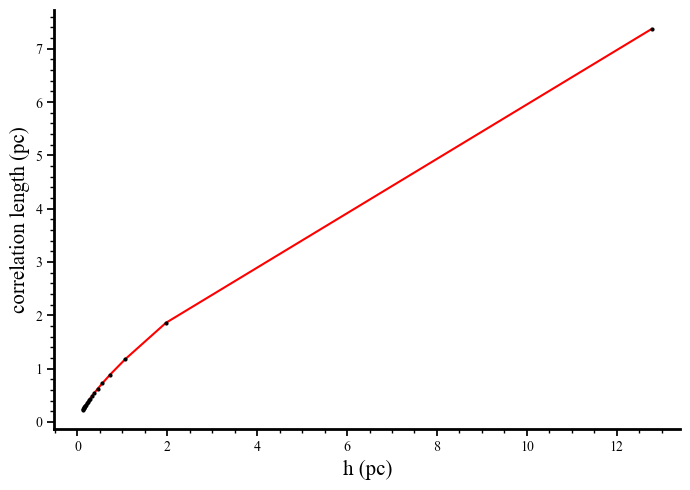

In [19]:
m = 2
dm = 2.5
fs = 15
lfs = 10
leg_textsize = 10
axis_textsize = 10
def axis_pars(ax):
    ax.tick_params(axis='both', which='minor',
                   labelsize=axis_textsize, colors='k', length=3, width=1)
    ax.tick_params(axis='both', which='major',
                   labelsize=axis_textsize, colors='k', length=5, width=1.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    # ax.legend(fontsize=lfs, frameon=False, handlelength=4, ncol=1, prop={
    #         'size': leg_textsize, 'family': 'Times New Roman'}, fancybox=True, framealpha=0.9, handletextpad=0.7, columnspacing=0.7)
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5), tight_layout=True)
ax.plot(mag_f[0], mag_f[1], c='r', linestyle='-', mfc='k',
              mec='k', markersize=m, marker='o', label=r' $h$(pc)')
axis_pars(ax)
ax.set_xlabel(r'h (pc)', fontsize=fs)
ax.set_ylabel(r'correlation length (pc)', fontsize=fs)